In [1]:
import numpy as np # importing numpy for matrix operations 
from scipy import *
from scipy.optimize import minimize
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display 
import itertools
from IPython.display import display
import random
import operator
from random import choices, randint, randrange, random, sample, seed, uniform, choice
from collections import namedtuple
from typing import List, Optional, Callable, Tuple
from functools import partial
sns.set()
import random


In [2]:
#np.random.seed(0)
#random.seed(0)

In [3]:
class IterRegistry(type):
    def __iter__(cls):
        return iter(cls._registry)

In [4]:
class MarketConfig: 
    #class attributes
    t0 = 2016 #The starting year for evaluation of the pay-offs
    T = 35  # Planning Horizon t = 2016,...,2040 # 100 year scope 
    year = np.arange(2016, 2051)
    distance = np.array([11810]) #nautical miles #Notteboom (2006)  
    port_time =  np.array([264])  #hours ==> 11 days in a year  #Notteboom (2006)
    demand_16_20 = np.array([1303780  for j in range(5)]) #in TEU #placehplder to be calibrated with the chosen route 
    annual_working_time = np.array([6480])  #hours per year, assumption   #hours per year, assumption 
    initial_freight_rate = np.array([1800])  ## in US$/TEU 
    SFOC_main = np.array([206])  #g/kWh, specific daily main engine fuel oil consumption rate
    SFOC_aux = np.array([221]) # specific fuel oil consumption of the auxiliary engine [g/kW h], 
    eng_load_main = np.array([0.8]) # % 
    eng_load_aux = np.array([0.5])  # engine load of the auxiliary engine [\%]


    def __init__(self, number_of_firms, pollution_decay_parameter, pollution_damage_parameter, demand_income_elasticity, demand_price_elasticity, 
                 freight_rate, fuel_data, discount_rate ):
        '''__init__ a method to describe the poperty that the shipping market and simulation game has'''
        self.number_of_firms = number_of_firms
        self.pollution_decay_parameter = pollution_decay_parameter
        self.pollution_damage_parameter = pollution_damage_parameter
        self.demand_income_elasticity = demand_income_elasticity #Constant income elasticity #IMF
        self.demand_price_elasticity =  demand_price_elasticity #Constant own price elasticity#IMF
        self.freight_rate = freight_rate ## in US$/TEU
        self.fuel_data = fuel_data 
        self.discount_rate = discount_rate 
        #self.bau_industry_emission =  bau_industry_emission 
        #self.bau_pollution_stock = bau_pollution_stock
        self.market_capacity = 0 
         
    
    def get_market_capacity (self, firm_instance):
        self.market_capacity += np.multiply(firm_instance.max_number_of_vessel, firm_instance.capacity) 
        return self.market_capacity 
    
    def get_freight_rate_ratio(self):
        self.beta = np.true_divide(self.freight_rate, MarketConfig.initial_freight_rate) 
        return self.beta
   
    def get_market_demand(self):
        '''compute market level demand'''
        #---------> 1.Import real GDP growth data & compute GDP ratio : Source IMF@2020 #
        G_df = pd.read_csv('./data/real_growth_rate.csv') #import IMF data
        #-------> 2.Construct GDP projection path 2016-2050 based on projection growth data 
        gdp_growth= G_df.values[:,1:] 
        g =1 +(gdp_growth/100)  
        self.gdp = np.array([100.00 for j in range(MarketConfig.T)])
        for foo in range (1,MarketConfig.T):
            self.gdp[foo] = g[:,foo]* self.gdp[foo-1]
        #print(self.gdp)
        #--------->  "compute GDP ratio based on IMF@2020"
        gdp_ratio = np.array([1.00 for j in range(MarketConfig.T)])
        for moo in range (1,MarketConfig.T):
            sub_g = g[:,0:moo+1]
            #print(sub_g)
            gdp_ratio[moo] = np.prod(sub_g)
        
        #--------->  "compute freight rate ratio"
        self.freight_rate_ratio_multiplied = np.power(self.beta, self.demand_price_elasticity)
        #print(freight_rate_ratio_multiplied)
        
        #---------> "Project Transport Demand (industry demand)"
        loo =np.multiply(np.power(gdp_ratio, self.demand_income_elasticity), self.freight_rate_ratio_multiplied ) #Will need to be updated in case fuel prices are varied over time  
        self.market_demand = np.multiply(loo, MarketConfig.demand_16_20[0])
        #print(Y) # size = 1 dimesion array with size T=35 years
        self.market_psy = np.multiply(np.power(gdp_ratio, self.demand_income_elasticity), MarketConfig.demand_16_20[0] )
        return self.market_demand, self.gdp, self.market_psy

In [5]:
class Firm:
    #class attributes intialisation, to be updated with the addition of each instance
    _registry = []
    
    def __init__(self, index, capacity, max_number_of_vessel, design_speed, 
                 min_speed, max_speed, main_engine_power, aux_engine_power,
                 fix_cost, fuel_type):
        '''__init__ a method to describe the poperty that all shipping firm have'''
        self._registry.append(self)
        self.index = index
        self.capacity = capacity # Vessel capacity in TEU per firm, 
        self.max_number_of_vessel = max_number_of_vessel # # of vessels per firms
        self.design_speed = design_speed  #design speed of the vessel in knots
        self.min_speed = min_speed #min vessel speed
        self.max_speed = max_speed #max vessel speed         
        self.main_engine_power =  main_engine_power  # PS_m : main engine power in kW
        self.aux_engine_power =  aux_engine_power  # auxiliary engine power [kW] 
        self.fix_cost = fix_cost #Daily cost of vessel (USD/Day) $25,000
        self.fuel_type = fuel_type
        #self.bau_emission = bau_emission
         
   
    # Firm methods 
    def get_market_share(self , market_instance):
        '''return market share of the firm accoding to it s capacity'''
        self.transport_capacity = np.multiply(self.max_number_of_vessel , self.capacity)
        self.market_share= np.true_divide(self.transport_capacity, market_instance.market_capacity)
        return self.market_share
        
    def get_firm_param(self, market_instance):
        self.psy = np.multiply (self.market_share , market_instance.market_psy)
        return self.psy
    
    def get_firm_demand(self, market_instance):
        self.firm_demand = np.multiply (self.market_share , market_instance.market_demand)
        return self.firm_demand 
    
    def update_vessel_speed(self, operational_speed):
        self.operational_speed = operational_speed
        return self.operational_speed 
    
    def get_min_number_of_vessel(self, market_instance):
        self.time_at_sea = np.true_divide(market_instance.distance,  self.operational_speed) #returns a vector 
        self.voyage_time = self.time_at_sea + market_instance.port_time #returns a vector 
        self.number_of_trips_to_meet_demand = np.true_divide(self.firm_demand, self.capacity) #returns a vector
        self.max_trips_per_vessel = np.true_divide(market_instance.annual_working_time, self.voyage_time) #returns a vector
        self.min_number_of_vessel_to_meet_demand = np.true_divide(self.number_of_trips_to_meet_demand, self.max_trips_per_vessel) #returns a vector
        return self.min_number_of_vessel_to_meet_demand, self.number_of_trips_to_meet_demand, self.time_at_sea 
    
    def get_number_of_vessel(self):
        self.number_of_vessel = np.ceil(self.min_number_of_vessel_to_meet_demand) #returns a vector
        return self.number_of_vessel
            
    def get_ship_energy_efficiency(self, market_instance):
        self.main_fuel_parameter =np.multiply(np.multiply(np.multiply(market_instance.SFOC_main,market_instance.eng_load_main),self.main_engine_power), 10**(-6))
        #self.main_fuel_parameter = market_instance.SFOC_main * market_instance.eng_load_main * self.main_engine_power * 10**(-6)
        self.ship_energy = np.multiply(self.main_fuel_parameter, np.power(self.design_speed, -3) )      
        return self.ship_energy
        
    def get_main_fuel_cons(self, market_instance):
        self.main_fuel_con= np.multiply(np.multiply(np.multiply(market_instance.distance, self.ship_energy), np.power(self.operational_speed, 2)) , self.number_of_trips_to_meet_demand)
        self.main_fuel_cons = market_instance.distance * self.ship_energy * (self.operational_speed**2) *self.number_of_trips_to_meet_demand
        return self.main_fuel_cons #returns a vector
        
    def get_aux_fuel_cons(self, market_instance): 
        self.aux_fuel_parameter = np.multiply(np.multiply(np.multiply( market_instance.SFOC_aux, market_instance.eng_load_aux), self.aux_engine_power),  10**(-6))
        #self.aux_fuel_parameter = market_instance.SFOC_aux * market_instance.eng_load_aux * self.aux_engine_power * 10**(-6)
        self.aux_fuel_cons =  np.true_divide((self.aux_fuel_parameter * self.number_of_trips_to_meet_demand * market_instance.distance), self.operational_speed)        
        return self.aux_fuel_cons #returns a vector   
    
        
    def get_fuel_cost(self, market_instance):
        self.aux_fuel_cost =np.multiply(self.aux_fuel_cons, market_instance.fuel_data['MGO']['price'])  
        self.main_fuel_cost = np.multiply(self.main_fuel_cons, market_instance.fuel_data[self.fuel_type]['price'])   
        self.fuel_cost = self.main_fuel_cost + self.aux_fuel_cost 
        return self.fuel_cost #returns a vector
    
    
    def get_firm_carbon_emission(self, market_instance):
        self.carbon_aux_emision_factor = market_instance.fuel_data['MGO']['carbon_factor']
        self_carbon_aux_emissions = np.multiply(self.carbon_aux_emision_factor, self.aux_fuel_cons )  
        self.carbon_main_emision_factor =  market_instance.fuel_data[self.fuel_type]['carbon_factor']
        self_carbon_main_emissions =np.multiply(self.carbon_main_emision_factor, self.main_fuel_cons)  
        self_carbon_emissions = self_carbon_main_emissions + self_carbon_aux_emissions 
        return self_carbon_emissions
    
    def get_firm_sulfur_emission(self, market_instance):
        self.sulfur_aux_emision_factor = market_instance.fuel_data['MGO']['sulfur_factor']
        self_sulfur_aux_emissions = np.multiply(self.sulfur_aux_emision_factor, self.aux_fuel_cons)  
        self.sulfur_main_emision_factor =  market_instance.fuel_data[self.fuel_type]['sulfur_factor']
        self_sulfur_main_emissions = np.multiply(self.sulfur_main_emision_factor, self.main_fuel_cons)  
        self_sulfur_emissions = self_sulfur_main_emissions + self_sulfur_aux_emissions 
        return self_sulfur_emissions      
    
            
    def get_total_cost(self):
        self.operating_cost = np.multiply(self.fix_cost, self.number_of_vessel)  #Fixed Cost
        self.total_cost = self.operating_cost + self.fuel_cost
        return self.total_cost #returns a vector    
    
    def update_total_cost(self, total_cost_with_policy):
        self.total_cost = total_cost_with_policy
        return self.total_cost 
                 
    def get_revenue(self,market_instance):
        self.revenue = np.multiply(self.firm_demand, market_instance.freight_rate)
        return self.revenue #returns a vector
    
    def get_period_profits(self):
        self.period_profit = self.revenue - self.total_cost
        return self.period_profit #returns a vector
    
    def get_discounted_period_profit(self,market_instance, planning_horizon):
        self.period_index_vector = np.arange(1,planning_horizon + 1)
        self.discount_multiplier = np.power( 1+ market_instance.discount_rate, - self.period_index_vector)
        self.discounted_period_profit = np.multiply( self.discount_multiplie, self.period_profit) 
        return self.discounted_period_profit #returns a vector



In [ ]:
#====> Iinitialisation of chromo and population objects 
Chromo = List[float] 
Population = List[Chromo]  

#====> Iinitialisation of function objects
PopulateFunc = Callable[[], Population]
FitnessFunc = Callable[[Chromo], Tuple[float, int, float, float]] #int to refelct max # of vessel
SelectionFunc = Callable[[Population, FitnessFunc], Tuple[Chromo, Chromo]]  #takes a population and a fitness fn to select 2 solutions to be the parents of our next generaation solution
CrossoverFunc = Callable[[Chromo, Chromo], Tuple[Chromo, Chromo]] #takes 2 genomes and returns 2 new genomes 
MutationFunc = Callable[[Chromo], Chromo] #takes 1 genome and sometimes returns a modified one

In [6]:

#======>
def generate_chromo(lower_bound:float, upper_bound:float, planning_horizon:int ,fitness_func: FitnessFunc) :
    while True:
        chromo = np.random.uniform(lower_bound, upper_bound, planning_horizon )   
        if fitness_func(chromo)[0] != 0:
            break
    return chromo  
#======>
def generate_population(fitness_func: FitnessFunc, 
                        size: int, chromo_lower_bound: float, 
                        chromo_upper_bound: float, planning_horizon:int ): 
    return np.array([generate_chromo(chromo_lower_bound, chromo_upper_bound, planning_horizon, fitness_func) for _ in range(size)])


#=====>
def selection_pair (population: Population, weights: list):
    return  np.random.choice(np.hstack( population),
                            size = 2, 
                            replace=False,
                            p= weights) 
#=======>
def BLX_alpha_crossover (a: Chromo, b: Chromo, chromo_lower_bound: float, chromo_upper_bound:float) :
    lower = min(a,b) -  0.5 * (max(a,b) - min (a,b))
    upper = max(a,b) +  0.5 * (max(a,b) - min (a,b))   
    lower = chromo_lower_bound if lower < chromo_lower_bound else lower
    upper = chromo_upper_bound if upper > chromo_upper_bound else upper
    return np.random.uniform (lower, upper, 2) 

#=====>
def mutation(chromo: Chromo, chromo_lower_bound: float, chromo_upper_bound: float
             , variance: float, probability: float = 0.5 ) : 
        chromo = np.random.normal(chromo, variance, 1) if random.random() > probability else chromo
        chromo = chromo_lower_bound if chromo <chromo_lower_bound else chromo
        chromo =chromo_upper_bound if chromo > chromo_upper_bound else chromo
        return chromo

The coevolution-based procedure steps:

	Step 1. Initialize the population for each player. The initialization can be done by randomly selecting solutions. 
    
	Step 2. Randomly select a player, h . Select an arbitrary chromosome randomly from the population for player h. 
    
	Step 3. Identify the scope of the evolving neighborhood (EN) of the selected chromosome. Select two parents from EN using the roulettewheel selection method (Lipowski & Lipowska, 2012). 
    
	Step 4. Generate two offspring by a crossover operation. Replace two individuals with the worst fitness value in EN with the two new offspring and then perform the mutation operation. 
    
	Step 5. Update the fitness values of the two offspring using the fitness evaluation procedure, which is described below. 
    
	Step 6. If any termination condition is satisfied, then stop; otherwise, go to the step 2. The two termination conditions are as follows: 
	the coevolving process runs for a predefined number of generations
	the deviation of the chromosome for each species is smaller than the pre-specified threshold, ψ


In [ ]:
def fitness_similarity_chech(max_fitness, number_of_similarity):
    result = 0
    similarity = 0
    for n in range(len(max_fitness)-1):
        if np.round(max_fitness[n], 3 ) == np.round(max_fitness[n+1],3):
            similarity += 1
        else:
            similarity = 0
    if similarity == number_of_similarity-1:
        result = 1
    return result



def chromo_deviation_chech(max_fitness, number_of_similarity):
    pass

In [ ]:
def scope_of_partners():
    """must returns #of firms -1 chromo """
    
# (1) Scope of partners: wt is the scope of the evolving neighborhood (EN)??
    
    #1. Entire population (SE) 
# all the chromosomes in the population of each of the other firms are candidate partners for the fitness evaluation.
    
    #2. Toroidal grids (ST) 
# Only include in the EN chromo, whose positions are in the neighboring toroidal girds
# of the chromosome to be evaluated
# Chromo in the same positions in the population of the other players,are candidate partners for the fitness evaluation. 

    
    pass

In [ ]:
# (2) Partner selection rules

def chromo_partner_selection():
    
#1. The best partner in the scope (PB):
# the chromosome with the highest fitness value in the scope of partners is selected as a partner for the fitness evaluation


# 1. Single partner by fitness-based random selection (PF):
    # the chromo in the scope of partners is selected randomly based on the fitness values of the chromosomes as a partner of each player
    #example
    #Assumption: the maximum number of selected candidate partners for the evaluation = 4
    #For firm 3, suppopse
    # P^3_32, P^3_33, P^3_22, P^3_43 are $ chromosomes with the highest fitness values in the SN. 
    # One partner among the four candidates is selected randomly with the selection probability dependent on their fitness values. 
    #Repeat the same for other symbiotic firms: 
    # Partners are selected in the same way for the other two species.
    # The chromo from the evolving firm is evaluated using the partners selected from each firm.


# 2. Multiple partners by fitness-based random selection (PM):
    # a prespecified number of partners are selected randomly from the scope based on their fitness values. All the selected partners of the other 
    #players are matched with the chromosome under consideration and
    # the average of all the fitness values of all the combinations of chromosomes is used as the fitness value of the corresponding chromosome.
    #example
    # Assumption: maximum number of selected candidate partners for the evaluation = 4. 
    # randonly select 4 partners from the scope of each firm based on their fitness values. 
    # 4 x 4  x 4 combinations of partners (3 symbootic firms) 
    # Results in 64 intergrated solution 
    #  fitness value of P^2_34 = the average fitness of the evolving firm using the 64 intergrated solutions


# 3. All the partners in the scope (PA):
    # all the chromosomes in the scope  of the other players are matched with the chromosome under
    # consideration and the average of all the fitness values of all the combinations of chromosomes is used as the fitness value of the
    # corresponding chromosome.
    #example:
    # all the chromosomes in each SN become candidate partners (bc 3by3 grid)
    # A total of 9x9x9  combinations of partners of three symbiotic firms are then made. 
    # generate  729 integrated solutions 
    # evalueate 729 fitness values of firm 1 
    #  fitness value of P^2_34 = The average value of 729 fitness values of firm one obtained from the 729 integrated solutions 

In [ ]:
#The individuals from a given firm are mapped into toroidal grids. 

# Let individual (m,n) denote an arbitrary location on the toroidal grids of the chromosome, 
# for which a neighborhood is defined for the evolution process, 
#  Nmn: 3x3 neighbors of the individual (m,n)


#The evolution of populations:
 #1st: 1 firm is selected randomly, which called the evolving firm., The other species are called symbiotic firms. 
 # 2nd, a location (m,n) is selected randomly 
# and the neighborhoods of the evolving firms and the symbiotic firms are specified. 


# EN = Nmn : The neighborhood of the evolving firm : 
# SN= Nmn :the neighborhood of an arbitrary symbiotic firm: 


#Selection :
# Two parents are selected from EN using the Roulette-wheel selection method 

#Crossover
# two offsprings are generated through a crossover operation.
# The worst two individuals in EN are replaced with the two offsprings. 


#mutation
# chromosomes from EN are selected randomly by using the mutation probability. 
# The mutation operation is implemented on the selected chromosomes. 

# Let:
# the evolving firms corresponding to the hth firm 
# a symbiotic firm corresponding to the lth player.

# P^h_ab in EN: the individual at (a, b) belonging to the evolving firm h, 
# P^l_cd in SN: a partner, ie, the individual with the best fitness value belonging a symbiotic firm,
# select  P^l_cd  for each  of the other players to Evaluate the fitness value of P^h_ab in EN :
# With the set of selected chromosomes,evaluate the fitness value of P^h_ab
# store Information on partners and the fitness value for each chromosome.


#Example: 
    #step 1: randomly select the evolving spiecy 
    # Step 2 : identify the rest of the firms as symbiotic spieies
    #Step 3: randomly select a chromo from the evolving firm's population:
        # chromo@ (3,3) of firm 2 is selected as the initial point for the evolution. 
    # Step4: we call on "Partner selection strategies" fn:  
    # and select The best partner in scope (PB):
        #example: P^1_33 P^3_43 P^4_23 are the individuals with the best fitness value belonging to the
        # SN in each symbiotic firm.
    #Step 5: evaluate the fitness of the randomly choson chromo P^2_34 using P^1_33, P^3_43, P^4_23
    #Step 6: combine to complete an integrated solution 

In [ ]:
#======>
def fitness_dynamic_taxation (chromo: Chromo, 
                              partner_chromo: chromo
                              firm: Firm, 
                              sim_game: MarketConfig, 
                              max_number_of_vessel: int,
                              planning_horizon: int,
                              initial_carbon_tax: int ,
                              taxation_scheme_rate: float,
                             industry_carbon_emission :float,
                             industry_sulfur_emission : float):
"""main issue: there are multiple populations competing with each other
and the profit of each player can be calculated only if a partner chromosome 
of each of other players is given
The main issue for CoGA is which chromo partner to select to evaluate the fitness function """







    operational_speed = firm.update_vessel_speed(chromo)    #vector of size T : [v1,v2,..,]
    min_number_vessels_sim , trips_to_meet_demand_sim, time_at_sea_sim  = firm.get_min_number_of_vessel(sim_game, period_index)
    number_vessels_sim  = firm.get_number_of_vessel()
    
    if number_vessels_sim > max_number_of_vessel:
        return np.zeros(4) #np.array([-9, -9, -9, -9])
    else:
        main_fuel_con_sim = firm.get_main_fuel_cons(sim_game)        
        aux_fuel_con_sim = firm.get_aux_fuel_cons(sim_game)
        fuel_cost_sim = firm.get_fuel_cost(sim_game)        
                
        carbon_emissions_sim = firm.get_firm_carbon_emission(sim_game)        
        sulfur_emissions_sim = firm.get_firm_sulfur_emission(sim_game)
        
               
        BAU_carbon_pollution_stock
        BAU_sulfur_pollution_stock
        dynamic_tax = np.zeros(MarketConfig.T+1)
        dynamic_tax[0] = initial_carbon_tax_sim
        
        #start the loop
        for my_period_index in range (MarketConfig.T+1):
            
        #Remove and multipy instead of using loop 
            BAU_carbon_pollution_stock[my_period_index + 1] = (1- pollution_decay_parameter ) * BAU_carbon_pollution_stock[my_period_index ] + carbon_industry_emission_period
            BAU_sulfur_pollution_stock[my_period_index+1] = (1- pollution_decay_parameter ) * BAU_sulfur_pollution_stock[my_period_index] + sulfur_industry_emission_period
             #Policy and Update Cost 
            dynamic_tax [my_period_index+1] = initial_carbon_tax_sim + taxation_scheme_rate_sim * BAU_carbon_pollution_stock[my_period_index +1 ]
            policy_cost = np.multiply(carbon_emissions_sim, dynamic_tax[period_index - 1 ]) # a numpy vectore
        
        
        BAU_industry_sulfur_damages = 0.5* pollution_damage_parameter * np.power(BAU_sulfur_pollution_stock,2)
        BAU_industry_carbon_damages = 0.5* pollution_damage_parameter * np.power(BAU_carbon_pollution_stock,2)       
            
        # break the loop
        total_cost_sim =  firm.get_total_cost()
        total_cost_sim_update =  total_cost_sim + policy_cost 
        total_cost = firm.update_total_cost(total_cost_sim_update)
        

        #Compute net present value
        revenues_sim = firm.get_revenue(sim_game, Update_total_cost_sim)        
        period_profits_sim = firm.get_period_profits()           
        discounted_period_profits_sim = firm.get_discounted_period_profit(sim_game, planning_horizon)             
        net_present_value = np.sum(discounted_period_profits_sim)
        return  net_present_value, discounted_period_profits_sim, number_vessels_sim, carbon_emissions_sim, sulfur_emissions_sim


In [ ]:
def run_co_evolution(populate_func: PopulateFunc, 
                  fitness_func: FitnessFunc, 
                  crossover_func: CrossoverFunc,
                  mutation_func: MutationFunc, 
                  generation_limit: int = 1000, 
                  number_of_similarity: int = 50, 
                  selection_func: SelectionFunc = selection_pair):
    """The evolutionnary main loop""" 
#I.Initialisation :
    #1.Initilise population for each player ; each chromo must have T genes 
    #result :  3 population 
    population_1 = populate_func(fitness_func)
    population_2 = populate_func(fitness_func)
    population_3 = populate_func(fitness_func)
    
    #2.Initilise fitness for each firm 
    
#II. Run the coevolutionnary loop :

#while (number_of_generation < generation_limit) or (chromo_deviation_chech() > deviation_threshold);
# the coevolving process runs for a predefined number of generations:
# the deviation of the chromosome for each species is smaller than the pre-specified threshold, ψ) == false:
    #1. Randomly select a firm, h. 
    #2. Randomly Select an arbitrary chromosome from the population for player h. 
    
    #3. Identify the scope of the evolving neighborhood (EN) of the selected chromosome. 
    
    #4. Selection function: 
        #Select two parents from EN using the roulettewheel selection method  
        #randomly select a location (m,n) from toroidal grids of firm h
    
    #5. Crossover function: 
        #Identify the scope of partners SP
        #Generate two offspring by a crossover operation. 
        # Replace the two worst individuals w in EN with the two new offspring 
        #evalute fitness of the new offspring 
        
    #6. mutation operation. 
    
    #7. Update the fitness values of the two offspring using the fitness evaluation procedure: fitness function
    
    
    
    #8. Check wether any termination condition is satisfied, then stop; otherwise, go to the step 2:     #2. Randomly select a firm, h. 
        #The two termination conditions are as follows: 
        # the coevolving process runs for a predefined number of generations
        # the deviation of the chromosome for each species is smaller than the pre-specified threshold, ψ

########    
    #2 Simulate until you reach generation limit,
    i = 0
    progress = pd.DataFrame(columns=['Generation', 'Vessel Speed', 'Firm Discounted profit', 
                                'Number of vessels', 'Carbon Emissions', 'Sulfur Emissions'])
    
    for i in range(generation_limit):
        #Step 1 : Sort solutions in the population of generation i based on fitness to select the best 2 solutions 
        population = sorted(population, key=lambda chromo: fitness_func(chromo)[0], reverse=True) 
        
        progress = progress.append({'Generation': i,
                          'Vessel Speed': population[0],
                          'Firm Discounted profit': fitness_func(population[0])[0],
                          'Number of vessels': fitness_func(population[0])[1] , 
                          'Carbon Emissions': fitness_func(population[0])[2] , 
                          'Sulfur Emissions': fitness_func(population[0])[3] }, ignore_index=True) 
        
        #Similarity check
        if fitness_similarity_chech(progress['Firm Discounted profit'], number_of_similarity) == 1:
            break
#         print(progress)
#         print (i)
#         print("Best vessel speed in the", i, "th generation is" ,population[0] ) 
#         print("Best fitness in the", i, "th generation is", fitness_func(population[0]))
    
              
        #Step 2: Implement elitism and pick the top 2 chromo(speed) in the population based on fitness for the next gernation 
        next_generation = population[0:2]      
        max = np.sum([fitness_func(chromo)[0] for chromo in population])
        weights= np.hstack([fitness_func(chromo)[0] / max for chromo in population])
        
        #Step 3: j in range 24 
        for j in range(int(len(population) / 2) - 1):
            #Step 1: Selection
            parents = selection_func(population, fitness_func, weights = weights)
            #print("parent are", parents) 
            
            #Step 2: Crossover
            offspring_a, offspring_b = crossover_func(parents[0], parents[1])
            

            #Step 3: mutation 
            offspring_a = mutation_func(offspring_a)
            offspring_b = mutation_func(offspring_b)
            #print("offspring a ", offspring_a) 
            #print("offspring b", offspring_b) 
            
            #Step 4: Next generation 
            next_generation += [offspring_a, offspring_b]
            
        #print("next generation",i, "is", next_generation)       
        population = next_generation #update current population with our next generation and start into the next round of the algo by sorting the population and checking if we reached our fitness limit 
    
    #Sort the population one last time in case we run out of generation  
    population = sorted(population, key=lambda chromo: fitness_func(chromo)[0], reverse=True)
    progress = progress.append({'Generation': i+1,
                          'Vessel Speed': population[0],
                          'Firm Discounted profit': fitness_func(population[0])[0],
                          'Number of vessels': fitness_func(population[0])[1] , 
                          'Carbon Emissions': fitness_func(population[0])[2] , 
                          'Sulfur Emissions': fitness_func(population[0])[3] }, ignore_index=True) 
    print(progress)
    
    
    # Resutls: 
#each firm has its final population , ie  a set of its chromosomes  
#each chromo has a fitness value and partners collected from the other population 
#during the fitness evaluation of the corresponding chromosome. 
# Each firm has a set of integrated solutions each of which consists of the chromo for all the firms.
    return progress


# termination conditions for the coevolution genetic algorithm :
#1. the maximum number of coevolving generations. 
#2. The deviation of fitness values becomes smaller than a pre-specified threshold value for all populations.


In [ ]:
def sequential_bidding_procedure():
# U[firm_j] ={d[i=0, firm1], d[i=1,firm1], ..., .} : 
# set of all the Pareto-optimal integrated solutions of firm j
# d: integrated solution
#d[i, firm_j] : ith Pareto-optimal integrated solution of firm j
# s_firm_j(d) :  solution of firm j in an integrated solution d.
# net_present_value[firm_j](d): net present value of firm j in an integrated solution d
# net_present_value[i, firm_j] : payoff of firm j in the i th Pareto-optimal integrated solution of firm j


#Step 1: inialisation: 
# Solution_set = np.empty
# i = 0 # ith Pareto-optimal integrated solution of the firm 


# Step 2:
 # i = i + 1
# for all firms j : for all firm_object in (Firm._registry):
    # if U[firm] is empty for any firm j:
        # there is no agreed solution, Stop break!
    #else:
            #Solution_set += d[i, firm_j] #add all firms 1st integrated solution to the solution set
            # U[firm_j].remve (d[i, firm_j]) #remove all  firms 1st  integrated solution from the set of all the Pareto-optimal integrated solutions of firm j U[firm_j]
  # Step 3:
  # Check for all firms whether there exists any integrated solution 'd' in Solution_set such that 
  # if net_present_value[firm_j](d[i,firm_j]) > net_present_value[firm_j](d): 
        # i = i +1  #increment the indices 
    #else :
    #d* = d #if If there is multiple d, then select d with the largest total payoff, as d*     


In [ ]:
def one_integrated_solution_selection():
    """ Select 1 integrated solution for all the firms 
A biding process  for deriving agreement among firms with multiple alternative solutions from the CoGA """
# to derive an agreement on the final solution among all the firms. 
# Rule:  The final agreement should satisfy each player as much as possible. 

#The bidding process:
    # each player submits one solution in each round 
    # until all the players agree with the same solution among all the solutions submitted thus far.

# Players agree with a solution if :
# (1) It is one of the Pareto optimal solutions among all the solutions the players have.
# (2) When the bidding process is applied, no other solution gives a higher profit to each player than the agreed solution.
#return a selected integreated solution 
    pass

In [ ]:
def local_search_procedure():
    """ perform a locaal serach using the selected solution
    fine tuning of the selected integrated solution with a local search 
    to find the  NE """  
#The iterative local search algorithm optimizes the solution of a player 
# to maximize the profit of the player with fixed solutions of the other players 
# until no player can increase its profit or a termination condition is met 
    pass 


# 1. Set Up Simulation Parameters:

## * Firm 1:

In [7]:
####################################### 1. Firm & Market specific Parameters ###########################################
                    #===========================>  Firm 1 Attributes <==========================#
index_1 = 1
capacity_1 = np.array([5905]) 
max_number_of_vessel_1= np.array([100]) 
design_speed_1 = np.array([23.3]) #design speed of the vessel in knots
min_speed_1 = np.array([10])
max_speed_1 = np.array([30])
main_engine_power_1 =np.array([41186])  # main engine power in kW
aux_engine_power_1 =np.array([2433])  # auxiliary engine power [kW] 
fix_cost_1 = np.array([6750000])   #Daily cost of vessel (USD/Day) $25,000
fuel_type_1 = "HFO"

## * Firm 2:

In [8]:
                    #===========================>  Firm 2 Attributes <==========================#
index_2 = 2
capacity_2 = np.array([6470])
max_number_of_vessel_2 = np.array([100])
design_speed_2 = np.array([24.7])  #design speed of the vessel in knots
min_speed_2 = np.array([10])
max_speed_2 = np.array([30])
main_engine_power_2 = np.array([56273]) # main engine power in kW
aux_engine_power_2 =np.array([2433])   # auxiliary engine power [kW] 
fix_cost_2 =np.array([ 6750000]) #Daily cost of vessel (USD/Day) $25,000
fuel_type_2 = "HFO"

## * Firm 3:

In [9]:
                    #===========================>  Firm 3 Attributes <==========================#
index_3 = 3
capacity_3 = np.array([6470])
max_number_of_vessel_3 = np.array([100])
design_speed_3 = np.array([24.7])  #design speed of the vessel in knots
min_speed_3 = np.array([10])
max_speed_3 = np.array([30])
main_engine_power_3 = np.array([56273]) # main engine power in kW
aux_engine_power_3 =np.array([2433])   # auxiliary engine power [kW] 
fix_cost_3 =np.array([ 6750000]) #Daily cost of vessel (USD/Day) $25,000
fuel_type_3 = "HFO"

## * Market :

In [10]:
                    #===========================> Market Attributes <==========================#
number_of_firms = 3
pollution_decay_parameter =  np.array([0.2])
pollution_damage_parameter =  np.array([1.5])

year = np.arange(2016, 2051)
income_elasticity = np.array([0.8]) #Constant income elasticity #IMF
price_elasticity = np.array([-0.7])   #Constant own price elasticity#IMF
freight_rate = np.array([1800]) ## in US$/TEU
fuel_data = pd.DataFrame(np.array([[422.50, 525.50, 597.00], 
                                [3.114,3.206,3.206],
                                [0.07,0.01,0.002]]),
                         columns=['HFO', 'ULSFO', 'MGO'],
                         index = ['price', 'carbon_factor', 'sulfur_factor'])
discount = np.array([0.02])  ##3  to 5 % transport canada ,#to be updated using the Ramsey rule,#pure rate of time preference of 1.5% + growth rate of consumption g * rate of risk conversion , an elasticity value of 2

# 2. Initialize Game and Set up firm and market objects 

In [11]:
""" This cell needs to run once throughout the kernel"""
####################################### 2.Simulation Game Initialisation ###########################################
firm_1 = Firm(index_1, capacity_1, max_number_of_vessel_1, design_speed_1, 
                 min_speed_1, max_speed_1, main_engine_power_1, aux_engine_power_1,
                 fix_cost_1, fuel_type_1) 

firm_2 = Firm(index_2, capacity_2, max_number_of_vessel_2, design_speed_2, 
                 min_speed_2, max_speed_2, main_engine_power_2, aux_engine_power_2,
                 fix_cost_2, fuel_type_2) 

firm_3 = Firm(index_3, capacity_3, max_number_of_vessel_3, design_speed_3, 
                 min_speed_3, max_speed_3, main_engine_power_3, aux_engine_power_3,
                 fix_cost_3, fuel_type_3) 



game_config = MarketConfig(number_of_firms, pollution_decay_parameter, pollution_damage_parameter, income_elasticity, price_elasticity, freight_rate, 
                           fuel_data, discount)

####################################### 3.Get market capacity #################################
for  firm_object in Firm._registry:
    market_capacity_sim = game_config.get_market_capacity(firm_object)

# 3. Market Demand

In [12]:
## Get freight ratio for passethrough
beta_sim = game_config.get_freight_rate_ratio()

# Get market demand  
market_demand_sim, gdp_sim, market_psy_sim = game_config.get_market_demand()
print("market demand", market_demand_sim)

# Get each firm's  market share  
firm_1_market_share_sim = firm_1.get_market_share(game_config)
print("firm 1 market share", firm_1_market_share_sim)

firm_2_market_share_sim = firm_2.get_market_share(game_config)
print("firm 2 market share", firm_2_market_share_sim)

firm_3_market_share_sim = firm_3.get_market_share(game_config)
print("firm 3 market share", firm_3_market_share_sim)

market demand [1303780.         1378613.27053661 1417081.19385409 1448735.913652
 1397511.98183639 1455352.28446974 1504050.11466377 1549602.07735933
 1594072.22320876 1638552.17226732 1684273.26074193 1731270.12057536
 1779578.35005746 1829234.54078948 1880276.30540081 1932742.30603904
 1986672.28365504 2042107.08810522 2099088.70909364 2157660.30797763
 2217866.2504608  2279752.14019835 2343364.85334008 2408752.57403719
 2475964.83093995 2545052.53471369 2616068.01660168 2689065.06806397
 2764098.98152235 2841226.59224218 2920506.32138292 3001998.22024985
 3085764.01578064 3171867.15730103 3260372.86458528]
firm 1 market share [0.31334572]
firm 2 market share [0.34332714]
firm 3 market share [0.34332714]


### Graphing Market Demand:

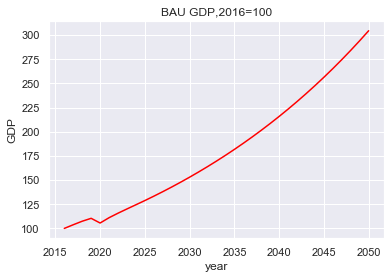

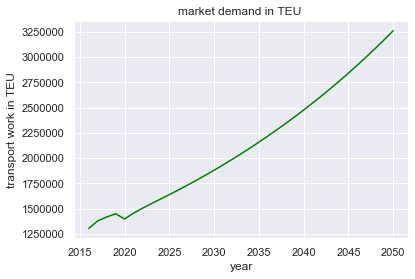

In [13]:
#======> Plotting BAU GDP,2016=100
sns.set()
ax=sns.lineplot(x=year ,y =gdp_sim, color = 'red')
ax.set(xlabel='year', ylabel='GDP')
plt.title("BAU GDP,2016=100" )
plt.show()

#======> Plotting Market Demand Projections in BAU senario: Y
ax=sns.lineplot(x=year ,y = market_demand_sim, color = 'green')
ax.set(xlabel='year', ylabel='transport work in TEU')
plt.title("market demand in TEU " )
plt.show()

#======> Plotting Marketshare per firm



## a. Firm 1:

In [14]:
 # 7.Get firm passthrough parameter
firm_1_psy_sim = firm_1.get_firm_param(game_config)

# 7.Get firm level demand  
firm_1_demand_sim = firm_1.get_firm_demand(game_config)
print("firm 1 demand", firm_1_demand_sim)
    
# 9.Get ship energy efficiency  
firm_1_ship_energy_sim = firm_1.get_ship_energy_efficiency(game_config)
print("firm 1 ship energy", firm_1_ship_energy_sim)

firm 1 demand [ 408533.87635978  431982.56102514  444036.3199633   453955.19077289
  437904.39123077  456028.40221777  471287.65864099  485561.17096348
  499495.70061277  513433.30205564  527759.8092163   542486.07386561
  557623.25057518  573182.80516646  589176.52339569  605616.51988116
  622515.24727954  639885.5057183   657740.45249127  676093.61202483
  694958.8861221   714350.56449304  734283.33557831  754772.29767522
  775832.97037412  797481.30631384  819733.70326521  842607.01655175
  866118.5718169   890286.17814752  915128.1415636   940663.27888434
  966910.93198114  993890.98242837 1021623.86656281]
firm 1 ship energy [0.00053659]


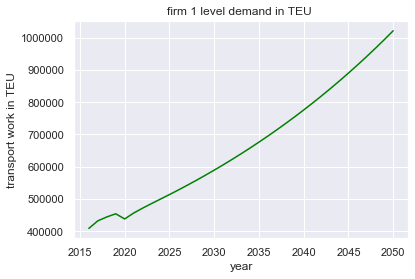

In [15]:
#======> Plotting The firm's 
ax=sns.lineplot(x=year ,y = firm_1_demand_sim , color = 'green')
ax.set(xlabel='year', ylabel='transport work in TEU')
plt.title("firm 1 level demand in TEU " )
plt.show()

## b. Firm 2

In [16]:
# 7.Get firm passthrough parameter
firm_2_psy_sim = firm_2.get_firm_param(game_config)

# 7.Get firm level demand  
firm_2_demand_sim = firm_2.get_firm_demand(game_config)
print("firm 2 demand", firm_2_demand_sim)


# 9.Get ship energy efficiency  
firm_2_ship_energy_sim = firm_2.get_ship_energy_efficiency(game_config)
print("firm 2 ship energy", firm_2_ship_energy_sim)

firm 2 demand [ 447623.06182011  473315.35475574  486522.4369454   497390.36143956
  479803.79530281  499661.94112599  516381.22801139  532020.45319792
  547288.26129799  562559.43510584  578256.72576282  594392.02335487
  610977.54974114  628025.86781151  645549.89100256  663562.89307894
  682078.51818775  701110.79119346  720674.12830119  740783.3479764
  761453.68216935  782700.78785266  804540.75888089  826990.13818098
  850065.93028291  873785.61419992  898167.15666823  923229.02575611
  948990.20485272  975470.20704733 1002689.08990966 1030667.47068276
 1059426.54189975 1088988.08743633 1119374.49901124]
firm 2 ship energy [0.00061541]


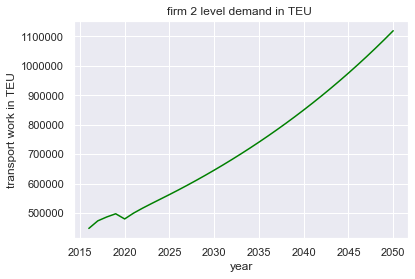

In [17]:
#======> Plotting The firm's 
ax=sns.lineplot(x=year ,y = firm_2_demand_sim , color = 'green')
ax.set(xlabel='year', ylabel='transport work in TEU')
plt.title("firm 2 level demand in TEU " )
plt.show()

## c. Firm 3

In [18]:
# 7.Get firm passthrough parameter
firm_3_psy_sim = firm_3.get_firm_param(game_config)

# 7.Get firm level demand  
firm_3_demand_sim = firm_3.get_firm_demand(game_config)
print("firm 3 demand", firm_3_demand_sim)


# 9.Get ship energy efficiency  
firm_3_ship_energy_sim = firm_3.get_ship_energy_efficiency(game_config)
print("firm 3 ship energy", firm_3_ship_energy_sim)

firm 3 demand [ 447623.06182011  473315.35475574  486522.4369454   497390.36143956
  479803.79530281  499661.94112599  516381.22801139  532020.45319792
  547288.26129799  562559.43510584  578256.72576282  594392.02335487
  610977.54974114  628025.86781151  645549.89100256  663562.89307894
  682078.51818775  701110.79119346  720674.12830119  740783.3479764
  761453.68216935  782700.78785266  804540.75888089  826990.13818098
  850065.93028291  873785.61419992  898167.15666823  923229.02575611
  948990.20485272  975470.20704733 1002689.08990966 1030667.47068276
 1059426.54189975 1088988.08743633 1119374.49901124]
firm 3 ship energy [0.00061541]


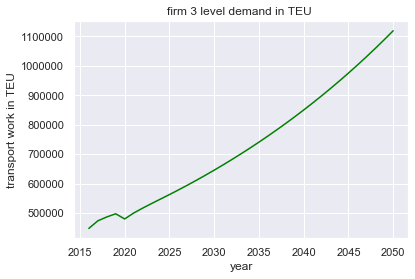

In [19]:
#======> Plotting The firm's 
ax=sns.lineplot(x=year ,y = firm_3_demand_sim , color = 'green')
ax.set(xlabel='year', ylabel='transport work in TEU')
plt.title("firm 3 level demand in TEU " )
plt.show()

##  c. Memership Decision and coalition formation

In [ ]:
initial_carbon_tax_sim = 20 #USD/ton
taxation_scheme_rate_sim = 0.04

In [ ]:
def BAU_emissions_period(p_index):
    results_period = {}
    optimum_solution_period ={}
    carbon_industry_emission_period = 0
    sulfur_industry_emission_period = 0
    for firm_object in (Firm._registry):
        results  = run_evolution(
            populate_func = partial(generate_population,
                                    size=50,
                                    chromo_lower_bound = firm_object.min_speed ,
                                    chromo_upper_bound = firm_object.max_speed, 
                                    planning_horizon = MarketConfig.T),
            fitness_func = partial(fitness,
                                   firm = firm_object,
                                   sim_game = game_config,
                                   max_number_of_vessel = firm_object.max_number_of_vessel,
                                   period_index = my_period_index),
            crossover_func = partial(BLX_alpha_crossover,
                                     chromo_lower_bound= firm_object.min_speed ,
                                     chromo_upper_bound = firm_object.max_speed),
            generation_limit = 100,
            number_of_similarity = 30,
            mutation_func = partial (mutation,
                                     variance = 0.009,
                                     chromo_lower_bound =  firm_object.min_speed,
                                     chromo_upper_bound= firm_object.max_speed,
                                     probability = 0.5))
        results_period["firm" + str(firm_object.index)] = results
        
        # Store Optimum Solution table     
        optimum_solution_period["firm" + str(firm_object.index)] = results_period["firm" + str(firm_object.index)].iloc[[-1]]

        # Compute industry level BAU emissions
        carbon_industry_emission_period += optimum_solution_period["firm" + str(firm_object.index)]["Carbon Emissions"].values
        sulfur_industry_emission_period += optimum_solution_period["firm" + str(firm_object.index)]["Sulfur Emissions"].values
        #print("carbon_industry_emission_period")
    #print(carbon_industry_emission_period)
    return results_period, optimum_solution_period, carbon_industry_emission_period, sulfur_industry_emission_period

In [ ]:
BAU_carbon_pollution_stock = np.zeros(MarketConfig.T+1)
BAU_sulfur_pollution_stock = np.zeros(MarketConfig.T+1)
results = {} #empty dict
optimum_solution={} #empty dict 
for my_period_index in range(MarketConfig.T):
    results_period, optimum_solution_period, carbon_industry_emission_period, sulfur_industry_emission_period = BAU_emissions_period(my_period_index +1)
    results[my_period_index+1]  = results_period
    optimum_solution [my_period_index +1 ] = optimum_solution_period # a dict ''    
    BAU_carbon_pollution_stock[my_period_index + 1] = (1- pollution_decay_parameter ) * BAU_carbon_pollution_stock[my_period_index ] + carbon_industry_emission_period
    BAU_sulfur_pollution_stock[my_period_index+1] = (1- pollution_decay_parameter ) * BAU_sulfur_pollution_stock[my_period_index] + sulfur_industry_emission_period

## c. Compute BAU emissions throughout the planning horizon

In [ ]:
#results[2]["firm1"]

In [ ]:
#optimum_solution[2]['firm1']

## Placeholders Analysis: No carbon emissions constraints policy

In [ ]:
firms = optimum_solution[1].keys()
periodes = optimum_solution.keys()

##### Discounted Period Profits

In [ ]:
Discounted_period_profits = pd.DataFrame(columns = firms,  index = periodes )
for periode in periodes:
    for firm in firms:
        Discounted_period_profits[firm][periode] = ((optimum_solution[periode][firm]["Firm Discounted profit"]).values).astype(float)
Discounted_period_profits

#####  Vessel Speed

In [ ]:
Vessel_speed_optimum = pd.DataFrame(columns = firms,  index = periodes )
for periode in periodes:
    for firm in firms:
        Vessel_speed_optimum[firm][periode] = ((optimum_solution[periode][firm]["Vessel Speed"]).values).astype(float)
Vessel_speed_optimum

#####  Number of vessels

In [ ]:
number_of_vessel_optimum = pd.DataFrame(columns = firms,  index = periodes )
for periode in periodes:
    for firm in firms:
        number_of_vessel_optimum[firm][periode] = ((optimum_solution[periode][firm]["Number of vessels"]).values).astype(float)
number_of_vessel_optimum

#####  Carbon Emissions Path

In [ ]:
carbon_emission = pd.DataFrame(columns = firms,  index = periodes )

for periode in periodes:
    for firm in firms:
        carbon_emission[firm][periode] = ((optimum_solution[periode][firm]["Carbon Emissions"]).values).astype(float)

carbon_emission.to_csv("carbonemissionpath")


plt.plot(list(range(1,MarketConfig.T+1)),carbon_emission)
plt.title("Carbon emission path " )
plt.ylabel('Carbon emissions')
plt.legend(labels  =carbon_emission.columns.tolist())
plt.show()

carbon_emission

### Sulfur Emission Path


In [ ]:
sulfur_emission = pd.DataFrame(columns = firms,  index = periodes )

for periode in periodes:
    for firm in firms:
        sulfur_emission[firm][periode] = ((optimum_solution[periode][firm]["Sulfur Emissions"]).values).astype(float)

        
plt.plot(list(range(1,MarketConfig.T+1)),sulfur_emission)
plt.title("Sulfur emission path " )
plt.ylabel('Sulfur emissions')
plt.legend(labels  = sulfur_emission.columns.tolist())
plt.show()



sulfur_emission.to_csv("sulfuremissionpath")
sulfur_emission

#####  Carbon and Sulfur Pollution Stock

In [ ]:
Pollution_Stock = pd.DataFrame(columns = ["Carbon Pollution Stock", "Sulfur Pollution Stock"] ,  index = periodes )

for periode in periodes:
    Pollution_Stock["Carbon Pollution Stock"][periode] = BAU_carbon_pollution_stock[periode -1]
    Pollution_Stock["Sulfur Pollution Stock"][periode] = BAU_sulfur_pollution_stock[periode -1]

# Create some mock data

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('periode')
ax1.set_ylabel('Carbon Pollution Stock', color=color)
ax1.plot(list(range(1,MarketConfig.T+1)), Pollution_Stock["Carbon Pollution Stock"], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Sulfur Pollution Stock', color=color)  # we already handled the x-label with ax1
ax2.plot(list(range(1,MarketConfig.T+1)), Pollution_Stock["Sulfur Pollution Stock"], color=color)
ax2.tick_params(axis='y', labelcolor=color)

#fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Pollution_Stock

#####  Carbon and Sulfur Pollution Damages

In [ ]:
sulfur_industry_carbon_damages = 0.5* pollution_damage_parameter * np.power(BAU_sulfur_pollution_stock,2)
#sulfur_industry_carbon_damages
BAU_industry_carbon_damages = 0.5* pollution_damage_parameter * np.power(BAU_carbon_pollution_stock,2)
#BAU_industry_carbon_damages

In [ ]:
Industry_Damages = pd.DataFrame(columns = ["Carbon Industry Damages", "Sulfur Industry Damages "] ,  index = periodes )

for periode in periodes:
    Industry_Damages["Carbon Industry Damages"][periode] = BAU_industry_carbon_damages[periode-1]
    Industry_Damages["Sulfur Industry Damages "][periode] = sulfur_industry_carbon_damages[periode-1]

    
    
# Create some mock data

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('periode')
ax1.set_ylabel("Carbon Industry Damages", color=color)
ax1.plot(list(range(1,MarketConfig.T+1)), Industry_Damages["Carbon Industry Damages"] , color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel("Sulfur Industry Damages ", color=color)  # we already handled the x-label with ax1
ax2.plot(list(range(1,MarketConfig.T+1)), Industry_Damages["Sulfur Industry Damages "] , color=color)
ax2.tick_params(axis='y', labelcolor=color)

#fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


Industry_Damages

### Evaluatin GA performance

### Profit,   Revenue, Cost CO2 Cost,  SOx Cos in 1 graph as a function of generation ??

### Firm 1, Period 1

In [ ]:
plt.plot(results[1]["firm1"]['Generation'].values, results[1]["firm1"]['Firm Discounted profit'].values)
plt.title("Convergence " )
plt.ylabel('Firm discounted profits')
plt.xlabel('Generation')
plt.show()
#############
plt.plot(results[1]["firm1"]['Vessel Speed'].values, results[1]["firm1"]['Firm Discounted profit'].values)
plt.title("Profits " )
plt.ylabel('Firm discounted profits')
plt.xlabel('Vessel Speed')
plt.show()

## Export Results to spreadsheet

In [ ]:
writer = pd.ExcelWriter('results.xlsx', engine='xlsxwriter')   
for periode in results.keys():
    for firm in results[periode].keys():
        sheet_name = "period" + str(periode) + firm
        results[periode][firm].to_excel(writer, sheet_name = sheet_name, index =False)
writer.save()

In [ ]:
writer_1 = pd.ExcelWriter('optimum_solution.xlsx', engine='xlsxwriter')   
for periode in optimum_solution.keys():
    for firm in optimum_solution[periode].keys():
        sheet_name = "period" + str(periode) + firm
        optimum_solution[periode][firm].to_excel(writer_1, sheet_name = sheet_name, index =False)
writer_1.save()

In [24]:
#"Singerons are denoted by '0' while signatories are denoted by '1'"
coalition_structure =np.asarray([list(i) for i in itertools.product([0, 1], repeat= number_of_firms)])
All_singelton = coalition_structure[0]
Grand_coalition  = coalition_structure[-1]
coalition_structure
#coalition_stru[3]

array([[0, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 1],
       [1, 0, 0],
       [1, 0, 1],
       [1, 1, 0],
       [1, 1, 1]])

In [36]:
for compteur in range (len(coalition_structure)): 
    coalition = np.where(coalition_structure[compteur] == 1)
    singleton = np.where(coalition_structure[compteur] == 0)
    print(coalition)

(array([], dtype=int64),)
(array([2], dtype=int64),)
(array([1], dtype=int64),)
(array([1, 2], dtype=int64),)
(array([0], dtype=int64),)
(array([0, 2], dtype=int64),)
(array([0, 1], dtype=int64),)
(array([0, 1, 2], dtype=int64),)


## Import BAU emissions, pollution stock and industry damages

### Benefits from abatement 

### coalition model : 
Assume am emission threshold -condition for joining the coalition 

gen = 0
for each species s do begin
Pops(gen) = randomly initialized population
evaluate fitness of each individual in Pops(gen)
end
while termination condition = false do begin
gen = gen + 1
for each species s do begin
select Pops(gen) from Pops(gen − 1) based on fitness
apply genetic operators to Pops(gen)
evaluate fitness of each individual in Pops(gen)
end
end